<a href="https://colab.research.google.com/github/sergey-jr/F19-20_ML/blob/master/AML_HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequirements

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
!wget https://raw.githubusercontent.com/spierre91/medium_code/master/russian_troll_tweets_classification_BERT/training_data.csv

! pip3 install ktrain comet_ml pytorch-pretrained-bert pytorch-nlp

--2020-02-23 10:46:23--  https://raw.githubusercontent.com/spierre91/medium_code/master/russian_troll_tweets_classification_BERT/training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24786476 (24M) [text/plain]
Saving to: ‘training_data.csv.1’

training_data.csv.1 100%[===================>]  23.64M   113MB/s    in 0.2s    

2020-02-23 10:46:24 (113 MB/s) - ‘training_data.csv.1’ saved [24786476/24786476]



# Imports

In [ ]:
from comet_ml import Experiment

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, Conv1D, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Data processing

In [ ]:
df = pd.read_csv("training_data.csv")
df = df[['text', 'type']]
df.isnull().values.any()

True

In [ ]:
df.shape

(207071, 2)

In [ ]:
df.head()

,text,type
0,RT @ActivistPost: World’s Largest Electronics ...,bot
1,"MUST WATCH\n\n""If they can't control their own...",bot
2,Watch Hillary Clinton's Full Speech at the 201...,bot
3,RT @trueblacknews: Could Rising Insurance Prem...,bot
4,@AnnoGalactic Happy New Year!,bot


In [ ]:
print(Counter(df['type'].values))

Counter({'bot': 203476, 'normal': 3582, nan: 13})


In [ ]:
df.dropna(inplace = True)
df_bot = df[df['type'] == 'bot'] 
df_normal = df[df['type'] == 'normal'] 
df_bot = df_bot.sample(n=len(df_normal))
df = df_normal.append(df_bot)
df = df.sample(frac=1, random_state = 24).reset_index(drop=True)
df['type'] = df['type'] == 'bot'
df['type'] = df['type'].astype('int64')

In [ ]:
Counter(df['type'].values)

Counter({0: 3582, 1: 3582})

In [ ]:
data = df.head(200)
features = data['text']
target = data['type']

In [ ]:
Counter(data['type'])

Counter({0: 93, 1: 107})

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

# Prepare data for models

In [ ]:
features = [preprocess_text(sen) for sen in features]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# glove.6B

In [ ]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-02-23 10:46:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-23 10:46:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-23 10:46:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#  Simple Neural network

In [ ]:
experiment1 = Experiment(api_key="lGk6i9quEJm9F3X6OCWpnBnwE",
                        project_name="general", workspace="sergey-jr")
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
experiment1.end()
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sergey-jr/general/97deb4dcc75a4649bbd8cf905f317d65

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train on 80 samples, validate on 20 samples
Epoch 1/10


COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


80/80 [==============================] - 2s 26ms/sample - loss: 0.7791 - acc: 0.4250 - val_loss: 0.7797 - val_acc: 0.4000
Epoch 2/10
80/80 [==============================] - 0s 157us/sample - loss: 0.7606 - acc: 0.4250 - val_loss: 0.7656 - val_acc: 0.4000
Epoch 3/10
80/80 [==============================] - 0s 161us/sample - loss: 0.7437 - acc: 0.4250 - val_loss: 0.7529 - val_acc: 0.4000
Epoch 4/10
80/80 [==============================] - 0s 148us/sample - loss: 0.7289 - acc: 0.4250 - val_loss: 0.7417 - val_acc: 0.4000
Epoch 5/10
80/80 [==============================] - 0s 152us/sample - loss: 0.7161 - acc: 0.4250 - val_loss: 0.7318 - val_acc: 0.4000
Epoch 6/10
80/80 [==============================] - 0s 201us/sample - loss: 0.7051 - acc: 0.4250 - val_loss: 0.7232 - val_acc: 0.4000
Epoch 7/10
80/80 [==============================] - 0s 146us/sample - loss: 0.6954 - acc: 0.4250 - val_loss: 0.7155 - val_acc: 0.4000
Epoch 8/10
80/80 [==============================] - 0s 151us/sample - loss

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sergey-jr/general/97deb4dcc75a4649bbd8cf905f317d65
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [10]                 : (0.42500001192092896, 0.42500001192092896)
COMET INFO:     batch_acc [10]           : (0.42500001192092896, 0.42500001192092896)
COMET INFO:     batch_loss [10]          : (0.6709685325622559, 0.779143214225769)
COMET INFO:     epoch_duration [10]      : (0.011249049000070954, 2.1151079940000272)
COMET INFO:     loss [10]                : (0.6709685325622559, 0.779143214225769)
COMET INFO:     step                     : 20
COMET INFO:     sys.cpu.percent.01       : (2.3, 2.3)
COMET INFO:     sys.cpu.percent.02       : (2.0, 2.0)
COMET INFO:     sys.cpu.percent.03       : (3.6, 3.6)
COMET INFO:     sys.cpu.percent.04       : (3.4, 3.4)
COMET INFO:     sys.cpu.percent.avg      : (2.825, 2.825)
COMET INFO:     sys

Accuracy (orange for train, blue for validation)<br>
![accuracy](https://c.radikal.ru/c36/2002/8c/3d16e3109835.jpg)
<br>Loss (orange for train, blue for validation)<br>
![loss](https://d.radikal.ru/d21/2002/f8/efb6b8bb4980.jpg)

# Convolutional neural network

In [ ]:
experiment2 = Experiment(api_key="lGk6i9quEJm9F3X6OCWpnBnwE",
                        project_name="general", workspace="sergey-jr")
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
experiment2.end()
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sergey-jr/general/b63cc751fb51458d96a0815acd95cbf0



Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 5s 62ms/sample - loss: 0.7518 - acc: 0.5625 - val_loss: 0.6866 - val_acc: 0.4500
Epoch 2/10
80/80 [==============================] - 0s 214us/sample - loss: 0.6170 - acc: 0.7375 - val_loss: 0.6772 - val_acc: 0.6000
Epoch 3/10
80/80 [==============================] - 0s 178us/sample - loss: 0.5255 - acc: 0.8500 - val_loss: 0.6431 - val_acc: 0.6500
Epoch 4/10
80/80 [==============================] - 0s 183us/sample - loss: 0.4316 - acc: 0.9500 - val_loss: 0.6191 - val_acc: 0.7000
Epoch 5/10
80/80 [==============================] - 0s 162us/sample - loss: 0.3664 - acc: 0.9500 - val_loss: 0.6097 - val_acc: 0.5500
Epoch 6/10
80/80 [==============================] - 0s 149us/sample - loss: 0.3222 - acc: 0.9500 - val_loss: 0.6028 - val_acc: 0.7000
Epoch 7/10
80/80 [==============================] - 0s 173us/sample - loss: 0.2820 - acc: 0.9500 - val_loss: 0.5967 - val_acc: 0.6500
Epoch 8/10
80/80 [=

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sergey-jr/general/b63cc751fb51458d96a0815acd95cbf0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [10]                 : (0.5625, 0.987500011920929)
COMET INFO:     batch_acc [10]           : (0.5625, 0.987500011920929)
COMET INFO:     batch_loss [10]          : (0.18516184389591217, 0.7518419027328491)
COMET INFO:     epoch_duration [10]      : (0.012172796999948332, 4.938168012999995)
COMET INFO:     loss [10]                : (0.18516184389591217, 0.7518419027328491)
COMET INFO:     step                     : 20
COMET INFO:     sys.cpu.percent.01       : (3.8, 3.8)
COMET INFO:     sys.cpu.percent.02       : (7.3, 7.3)
COMET INFO:     sys.cpu.percent.03       : (1.8, 1.8)
COMET INFO:     sys.cpu.percent.04       : (5.6, 5.6)
COMET INFO:     sys.cpu.percent.avg      : (4.625, 4.625)
COMET INFO:     sys.gpu.0.free_memory    : (16

Accuracy (orange for train, blue for validation)<br>
![accuracy](https://b.radikal.ru/b12/2002/40/13461be45d55.jpg)
<br>Loss (orange for train, blue for validation)<br>
![loss](https://d.radikal.ru/d00/2002/1e/4de141d482a7.jpg)

# Recurent Neural Network (LSTM)

In [ ]:
experiment3 = Experiment(api_key="lGk6i9quEJm9F3X6OCWpnBnwE",
                        project_name="general", workspace="sergey-jr")
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
experiment3.end()
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sergey-jr/general/f7d5f0ad0f65421dbd875808c1ea8c40



Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 1s 15ms/sample - loss: 0.6931 - acc: 0.4000 - val_loss: 0.6916 - val_acc: 0.6000
Epoch 2/10
80/80 [==============================] - 0s 272us/sample - loss: 0.6920 - acc: 0.5750 - val_loss: 0.6898 - val_acc: 0.6000
Epoch 3/10
80/80 [==============================] - 0s 258us/sample - loss: 0.6907 - acc: 0.5750 - val_loss: 0.6877 - val_acc: 0.6000
Epoch 4/10
80/80 [==============================] - 0s 267us/sample - loss: 0.6892 - acc: 0.5750 - val_loss: 0.6850 - val_acc: 0.6000
Epoch 5/10
80/80 [==============================] - 0s 252us/sample - loss: 0.6873 - acc: 0.5750 - val_loss: 0.6815 - val_acc: 0.6000
Epoch 6/10
80/80 [==============================] - 0s 280us/sample - loss: 0.6851 - acc: 0.5750 - val_loss: 0.6772 - val_acc: 0.6000
Epoch 7/10
80/80 [==============================] - 0s 292us/sample - loss: 0.6826 - acc: 0.5750 - val_loss: 0.6730 - val_acc: 0.6000
Epoch 8/10
80/80 [=

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sergey-jr/general/f7d5f0ad0f65421dbd875808c1ea8c40
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [10]                 : (0.4000000059604645, 0.574999988079071)
COMET INFO:     batch_acc [10]           : (0.4000000059604645, 0.574999988079071)
COMET INFO:     batch_loss [10]          : (0.6798197627067566, 0.6931471824645996)
COMET INFO:     epoch_duration [10]      : (0.02021630699994148, 1.2244154989999743)
COMET INFO:     loss [10]                : (0.6798197627067566, 0.6931471824645996)
COMET INFO:     step                     : 20
COMET INFO:     sys.cpu.percent.01       : (3.7, 3.7)
COMET INFO:     sys.cpu.percent.02       : (4.6, 4.6)
COMET INFO:     sys.cpu.percent.03       : (8.9, 8.9)
COMET INFO:     sys.cpu.percent.04       : (7.8, 7.8)
COMET INFO:     sys.cpu.percent.avg      : (6.250000000000001, 6.250000000000001)


Accuracy (orange for train, blue for validation)<br>
![accuracy](https://a.radikal.ru/a11/2002/0a/0859a9fbe3f9.jpg)
<br>Loss (orange for train, blue for validation)<br>
![loss](https://a.radikal.ru/a32/2002/57/2b8c773fb789.jpg)

# GRU

In [ ]:
experiment3 = Experiment(api_key="lGk6i9quEJm9F3X6OCWpnBnwE",
                        project_name="general", workspace="sergey-jr")
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(GRU(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
experiment3.end()
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sergey-jr/general/56e3098a3b264498a577a51ccbfcfee1



Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 1s 17ms/sample - loss: 0.6931 - acc: 0.4250 - val_loss: 0.6911 - val_acc: 0.6000
Epoch 2/10
80/80 [==============================] - 0s 266us/sample - loss: 0.6916 - acc: 0.5750 - val_loss: 0.6890 - val_acc: 0.6000
Epoch 3/10
80/80 [==============================] - 0s 275us/sample - loss: 0.6901 - acc: 0.5750 - val_loss: 0.6868 - val_acc: 0.6000
Epoch 4/10
80/80 [==============================] - 0s 263us/sample - loss: 0.6885 - acc: 0.5750 - val_loss: 0.6846 - val_acc: 0.6000
Epoch 5/10
80/80 [==============================] - 0s 257us/sample - loss: 0.6870 - acc: 0.5750 - val_loss: 0.6822 - val_acc: 0.6000
Epoch 6/10
80/80 [==============================] - 0s 228us/sample - loss: 0.6855 - acc: 0.5750 - val_loss: 0.6799 - val_acc: 0.6000
Epoch 7/10
80/80 [==============================] - 0s 221us/sample - loss: 0.6841 - acc: 0.5750 - val_loss: 0.6776 - val_acc: 0.6000
Epoch 8/10
80/80 [=

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sergey-jr/general/56e3098a3b264498a577a51ccbfcfee1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [10]                 : (0.42500001192092896, 0.574999988079071)
COMET INFO:     batch_acc [10]           : (0.42500001192092896, 0.574999988079071)
COMET INFO:     batch_loss [10]          : (0.6818901300430298, 0.6931471824645996)
COMET INFO:     epoch_duration [10]      : (0.017907837000052496, 1.3819180880000204)
COMET INFO:     loss [10]                : (0.6818901300430298, 0.6931471824645996)
COMET INFO:     step                     : 20
COMET INFO:     sys.cpu.percent.01       : (22.3, 22.3)
COMET INFO:     sys.cpu.percent.02       : (3.5, 3.5)
COMET INFO:     sys.cpu.percent.03       : (4.6, 4.6)
COMET INFO:     sys.cpu.percent.04       : (3.2, 3.2)
COMET INFO:     sys.cpu.percent.avg      : (8.4, 8.4)
COMET INFO:     sys.gpu

Accuracy (orange for train, blue for validation)<br>
![accuracy](https://a.radikal.ru/a11/2002/0a/0859a9fbe3f9.jpg)
<br>Loss (orange for train, blue for validation)<br>
![loss](https://a.radikal.ru/a32/2002/57/2b8c773fb789.jpg)

# BERT preprocessing

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
import torch.nn as nn

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_data, test_data = train_test_split(
    data, test_size=0.5, random_state=42)

print(Counter(train_data['type'].values))
print(Counter(test_data['type'].values))

train_data = [{'text': text, 'type': type_data } for text in list(train_data['text']) for type_data in list(train_data['type'])]
test_data = [{'text': text, 'type': type_data } for text in list(test_data['text']) for type_data in list(test_data['type'])]

train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['type']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['type']), test_data)))

train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=128, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=128, truncating="post", padding="post", dtype="int")

train_y = np.array(train_labels)
test_y = np.array(test_labels)

100%|██████████| 231508/231508 [00:00<00:00, 426375.76B/s]


Counter({1: 58, 0: 42})
Counter({0: 51, 1: 49})


In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

# ELMO

In [ ]:
nltk.download('punkt')
token_length = []
ds = [nltk.word_tokenize(preprocess_text(sen.lower())) for sen in df['text']][:200]
token_length = [len(token) for token in ds]

for sen in ds[:5]:
  print(sen)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['day', 'late', 'and', 'dollar', 'short', 'super', 'thankful', 'for', 'this', 'human', 'dealing', 'with', 'my', 'sassy', 'attitude', 'on', 'daily', 'basis', 'https', 'co', 'yuhxjo', 'wvm']
['thankful', 'for', 'my', 'big', 'family', 'they', 'll', 'never', 'let', 'me', 'feel', 'alone']
['rt', 'kimmybalgoa', 'pzchrstnnn', 'happy', 'birthday', 'beauty', 'queen', 'ganda', 'mo', 'parin']
['rt', 'kathy', 'montufar', 'lmao', 'me', 'every', 'time', 'go', 'into', 'shelter', 'or', 'pet', 'store', 'https', 'co', 'nxrpvvcpos']
['year', 'old', 'black', 'child', 'on', 'free', 'lunch', 'program', 'arrested', 'charged', 'standing', 'trial', 'for', 'milk', 'https', 'co', 'nchutzlg']


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.manifold import TSNE

In [ ]:
len(ds), len(token_length), sum(token_length)

(200, 200, 3460)

In [ ]:
max_length = 100

padded_text =  pad_sequences(ds, maxlen=max_length, padding='post', dtype=object, value='PADDED')
tokens_ = tf.convert_to_tensor(padded_text)
token_length_ = tf.convert_to_tensor(token_length)

elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/2", trainable=False, signature='tokens',signature_outputs_as_dict=True)
all_elmo_embeddings = elmo(inputs={'tokens':tokens_,'sequence_len':token_length_})
elmo_embeddings = all_elmo_embeddings['word_emb']
# print(elmo_embeddings)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
import csv
np_elmo_embeddings = elmo_embeddings.numpy()
with open('elmo_embeddings.tsv', mode='w', encoding='utf-8') as f:
  csv_writer = csv.writer(f, delimiter='\t')
  for i, sen in enumerate(np_elmo_embeddings):
    for vec in sen[:token_length[i]]:
      csv_writer.writerow(vec)
with open('elmo_metadata.tsv', mode='w', encoding='utf-8') as f:
  for i, sen in enumerate(ds):
    for word in sen:
      f.write(word + '\n')

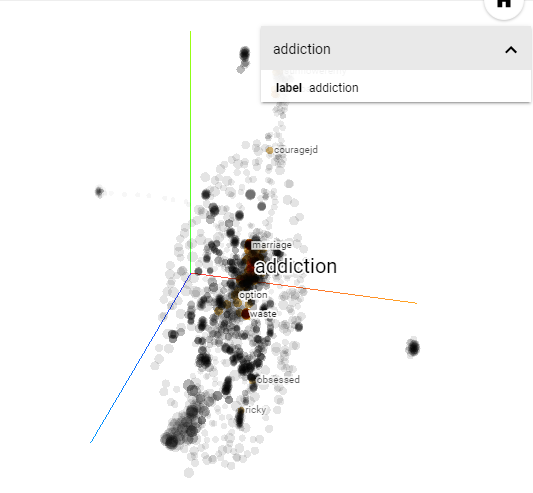

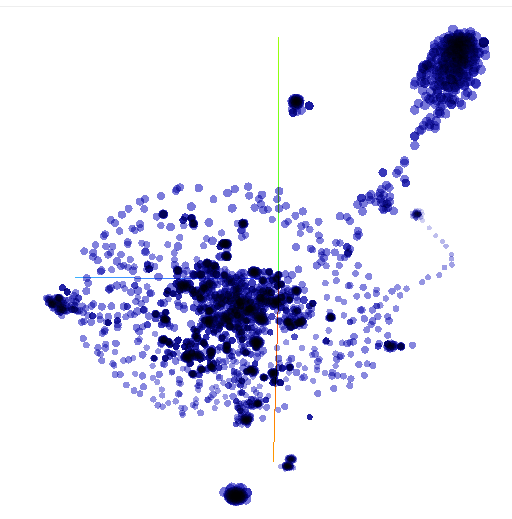

# Birt Classification

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

In [ ]:
BATCH_SIZE = 25
EPOCHS = 1
bert_clf = BertBinaryClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)

100%|██████████| 407873900/407873900 [00:34<00:00, 11688131.30B/s]


In [ ]:
train_dataset =  torch.utils.data.TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler =  torch.utils.data.RandomSampler(train_dataset)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_dataset =  torch.utils.data.TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler =  torch.utils.data.SequentialSampler(test_dataset)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
experiment4 = Experiment(api_key="lGk6i9quEJm9F3X6OCWpnBnwE",
                        project_name="general", workspace="sergey-jr")
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sergey-jr/general/62eb8b3fe0c84436b7d4d64334237ff0



Epoch:  1
0/400.0 loss: 0.713276207447052 
Epoch:  1
1/400.0 loss: 0.7134280502796173 
Epoch:  1
2/400.0 loss: 0.7123607794443766 
Epoch:  1
3/400.0 loss: 0.7097123265266418 
Epoch:  1
4/400.0 loss: 0.7006629943847656 
Epoch:  1
5/400.0 loss: 0.6969920992851257 
Epoch:  1
6/400.0 loss: 0.6973567179271153 
Epoch:  1
7/400.0 loss: 0.6935303881764412 
Epoch:  1
8/400.0 loss: 0.694702234533098 
Epoch:  1
9/400.0 loss: 0.6938536107540131 
Epoch:  1
10/400.0 loss: 0.6885500387711958 
Epoch:  1
11/400.0 loss: 0.6896787037452062 
Epoch:  1
12/400.0 loss: 0.6887068381676307 
Epoch:  1
13/400.0 loss: 0.686895170382091 
Epoch:  1
14/400.0 loss: 0.6891639590263366 
Epoch:  1
15/400.0 loss: 0.6902812980115414 
Epoch:  1
16/400.0 loss: 0.6897030016955208 
Epoch:  1
17/400.0 loss: 0.6914180517196655 
Epoch:  1
18/400.0 loss: 0.688462003281242 
Epoch:  1
19/400.0 loss: 0.6875656008720398 
Epoch:  1
20/400.0 loss: 0.6842142002923148 
Epoch:  1
21/400.0 loss: 0.6848138462413441 
Epoch:  1
22/400.0 loss:

In [ ]:
from sklearn.metrics import classification_report

bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):
token_ids, masks, labels = tuple(t for t in batch_data)
logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])
experiment4.end()        
print(classification_report(test_y, bert_predicted))